reference :https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

In [9]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
# import model
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [10]:
features = 16
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=features, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, features)

        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var

## Prep Dataset

In [17]:
# leanring parameters
epochs = 10
batch_size = 64
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [15]:
# train and validation data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    # download=True,
    transform=transform
)
val_data = datasets.MNIST(
    root='input/data',
    train=False,
    # download=True,
    transform=transform
)

In [18]:
# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)

In [19]:
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [20]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [25]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [23]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"outputs/output{epoch}.png", nrow=num_rows)

    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [28]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 10


938it [00:10, 89.69it/s]                                                                                               
157it [00:01, 140.02it/s]                                                                                              


Train Loss: 150.0760
Val Loss: 138.1756
Epoch 2 of 10


938it [00:10, 91.77it/s]                                                                                               
157it [00:01, 135.63it/s]                                                                                              


Train Loss: 133.4304
Val Loss: 127.9230
Epoch 3 of 10


938it [00:10, 92.97it/s]                                                                                               
157it [00:01, 98.75it/s]                                                                                               


Train Loss: 126.1979
Val Loss: 122.6339
Epoch 4 of 10


938it [00:10, 91.87it/s]                                                                                               
157it [00:01, 113.56it/s]                                                                                              


Train Loss: 121.9299
Val Loss: 119.0921
Epoch 5 of 10


938it [00:10, 91.03it/s]                                                                                               
157it [00:01, 121.12it/s]                                                                                              


Train Loss: 119.0648
Val Loss: 116.8415
Epoch 6 of 10


938it [00:10, 90.88it/s]                                                                                               
157it [00:01, 94.30it/s]                                                                                               


Train Loss: 117.0827
Val Loss: 115.2447
Epoch 7 of 10


938it [00:10, 89.38it/s]                                                                                               
157it [00:01, 140.89it/s]                                                                                              


Train Loss: 115.5950
Val Loss: 113.9166
Epoch 8 of 10


938it [00:10, 92.63it/s]                                                                                               
157it [00:01, 82.97it/s]                                                                                               


Train Loss: 114.3477
Val Loss: 112.8852
Epoch 9 of 10


938it [00:10, 91.69it/s]                                                                                               
157it [00:01, 142.89it/s]                                                                                              


Train Loss: 113.3241
Val Loss: 112.0268
Epoch 10 of 10


938it [00:10, 91.24it/s]                                                                                               
157it [00:01, 98.95it/s]                                                                                               

Train Loss: 112.4654
Val Loss: 111.1992


In [29]:
import pandas as pd
train_result = pd.DataFrame({
  "train_loss" : train_loss,
  "val_loss":val_loss 
})


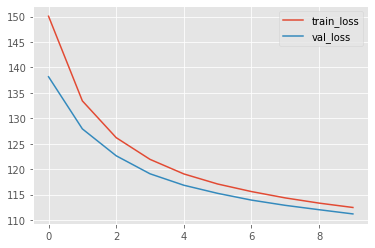

In [32]:
train_result.plot();